# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

# Data

In [103]:
# file name
file_name = 'data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv'

# read data
df = pd.read_csv(file_name)

# convert date to datetime object
df['Date'] = pd.to_datetime(df['Date'])

# inspect data
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [104]:
# filter data
df_TMAX = df[df['Element']=='TMAX'].reset_index(drop=True)
df_TMIN = df[df['Element']=='TMIN'].reset_index(drop=True)

In [105]:
# merge MAX and MIN dataframes
df = pd.merge(left=df_TMAX, right=df_TMIN, left_on=['ID','Date'], right_on=['ID','Date'],how='outer')
df = df.rename(columns={'Data_Value_x':'TMAX','Data_Value_y':'TMIN'})
df = df.drop(['Element_x','Element_y'],axis=1)

In [106]:
# extract day and month of dates
df['MonthDay'] = df['Date'].apply(lambda x: '{0:02}/{1:02}'.format(x.month,x.day))

In [107]:
# delete 02-29
df = df[df['MonthDay']!='02/29']

# convert data from tenth of degrees (C) to degrees (C)
df['TMAX'] = df['TMAX'].multiply(0.1)
df['TMIN'] = df['TMIN'].multiply(0.1)

# extract 2015
df_2015 = df[df['Date'].dt.year==2015]

# remove 2015
df = df[df['Date'].dt.year!=2015]

In [108]:
# group data
df_group = df.groupby('MonthDay')['TMAX','TMIN'].agg({'TMAX':np.max,'TMIN':np.min})
df_2015_group = df_2015.groupby('MonthDay')['TMAX','TMIN'].agg({'TMAX':np.max,'TMIN':np.min})

# sort by index
df_group = df_group.sort_index()
df_2015_group = df_2015_group.sort_index()
df_group = df_group.reset_index()
df_2015_group = df_2015_group.reset_index()

In [109]:
# 2015 data

# merge data of 2015 with grouped data
df_2015_group_merge = pd.merge(left=df_2015_group,right=df_group,
                               left_index=True,right_index=True,
                               suffixes=('_2015',''))


df_2015_group_merge['rec_max'] = (df_2015_group_merge['TMAX_2015']>df_2015_group_merge['TMAX']) * df_2015_group_merge['TMAX_2015']
df_2015_group_merge['rec_min'] = (df_2015_group_merge['TMIN_2015']<df_2015_group_merge['TMIN']) * df_2015_group_merge['TMIN_2015']

df_2015_max = df_2015_group_merge[df_2015_group_merge['rec_max']!=0]
df_2015_min = df_2015_group_merge[df_2015_group_merge['rec_min']!=0]

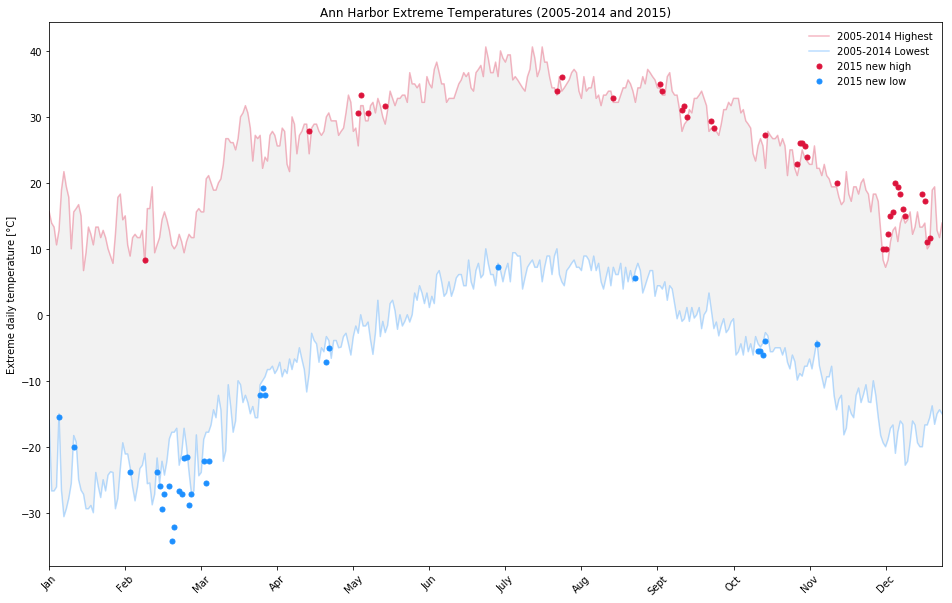

In [110]:
# PLOT

# create figure
f, ax = plt.subplots(figsize=(16,10))

# plot each series (TMAX and TMIN)
df_group['TMAX'].plot(ax=ax,label='2005-2014 Highest',color='crimson',alpha=0.3)
df_group['TMIN'].plot(ax=ax,label='2005-2014 Lowest',color='dodgerblue',alpha=0.3)

# fill the area between the max data and min data
ax.fill_between(range(len(df_group['TMIN'])), 
                       df_group['TMIN'], df_group['TMAX'], 
                       facecolor='grey', 
                       alpha=0.10)

# plot the 2015 data
df_2015_max['rec_max'].plot(ax=ax,label='2015 new high',marker='o',linewidth=0,markersize=5,color='crimson')
df_2015_min['rec_min'].plot(ax=ax,label='2015 new low',marker='o',linewidth=0,markersize=5,color='dodgerblue')

# set x ticks
ax.set_xticks(range(0,365,31))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sept','Oct','Nov','Dec'],rotation=45)

# set texts
ax.set_ylabel('Extreme daily temperature [°C]')
ax.set_xlabel('')
ax.set_title('Ann Harbor Extreme Temperatures (2005-2014 and 2015)')
ax.legend(frameon=False)

f.savefig('TAD_plot');